In [1]:
## Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## LOAD DATA AND EXPLORATORY ANALYSIS

In [3]:
## Load dataset and drop unusefull columns
X_full = pd.read_csv('methods_dataset.csv')
X_full.shape

(295815, 15)

In [4]:
## Initial data treatment
X_full.drop(['longMethod'], axis=1, inplace=True)
X_full.drop(['Unnamed: 0'],axis=1,inplace=True)
X_full.dropna(inplace=True)
X_full.shape

(295815, 13)

In [5]:
## Show dataframe header
X_full.head(1)

,fanin,fanout,wmc,loc,returnsQty,variablesQty,parametersQty,loopQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,uniqueWordsQty,featureEnvy
0,0,1,1,3,0,0,1,0,0,0,0,10,0


In [6]:
## Is any empty feature?
np.any(np.isnan(X_full))

False

In [7]:
## SPLIT DATA

In [8]:
## Split dataset in metrics and godsmell ds
X = X_full.drop(['featureEnvy'], axis=1)
y = X_full.featureEnvy

In [9]:
SEED=0

In [10]:
## Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [11]:
## Show train size
X_train.shape

(236652, 12)

In [12]:
## Show test size
X_test.shape

(59163, 12)

In [13]:
## CREATE PIPELINE

In [14]:
## Import ML algorithm
from sklearn.ensemble import RandomForestClassifier

In [15]:
## Create instance
randForest = RandomForestClassifier(random_state=SEED)

In [16]:
pipe = Pipeline(steps=[
            ('randForest', randForest)
    ])

In [17]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randForest', 'randForest__bootstrap', 'randForest__ccp_alpha', 'randForest__class_weight', 'randForest__criterion', 'randForest__max_depth', 'randForest__max_features', 'randForest__max_leaf_nodes', 'randForest__max_samples', 'randForest__min_impurity_decrease', 'randForest__min_impurity_split', 'randForest__min_samples_leaf', 'randForest__min_samples_split', 'randForest__min_weight_fraction_leaf', 'randForest__n_estimators', 'randForest__n_jobs', 'randForest__oob_score', 'randForest__random_state', 'randForest__verbose', 'randForest__warm_start'])

In [18]:
max_features = ['sqrt', 'log2']
n_estimators = [10, 100, 1000]
min_samples_leaf = [1, 2, 5, 10]

parameters = dict(
    randForest__max_features=max_features,
    randForest__n_estimators=n_estimators,
    randForest__min_samples_leaf=min_samples_leaf)

In [19]:
## TUNING THE MODEL

In [20]:
## Import libs
from sklearn.model_selection import RandomizedSearchCV, KFold

In [21]:
## Randomized Search Instance
randomized_search = RandomizedSearchCV(pipe,parameters,cv = KFold(n_splits=10),n_iter=10,random_state=SEED,scoring='neg_mean_squared_error')

In [22]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('randForest',
                                              RandomForestClassifier(random_state=0))]),
                   param_distributions={'randForest__max_features': ['sqrt',
                                                                     'log2'],
                                        'randForest__min_samples_leaf': [1, 2,
                                                                         5,
                                                                         10],
                                        'randForest__n_estimators': [10, 100,
                                                                     1000]},
                   random_state=0, scoring='neg_mean_squared_error')

In [23]:
resultados = pd.DataFrame(randomized_search.cv_results_)
resultados.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randForest__n_estimators,param_randForest__min_samples_leaf,param_randForest__max_features,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,240.674005,6.442429,3.373434,0.071059,1000,10,sqrt,"{'randForest__n_estimators': 1000, 'randForest...",-0.016226,-0.015761,...,-0.0161,-0.01517,-0.015297,-0.01517,-0.016396,-0.015001,-0.016184,-0.015571,0.000622,9
1,24.201671,0.904055,0.332777,0.016121,100,10,sqrt,"{'randForest__n_estimators': 100, 'randForest_...",-0.016226,-0.015761,...,-0.0161,-0.01517,-0.015297,-0.01517,-0.016396,-0.014959,-0.016184,-0.015563,0.000634,7


In [24]:
## Print best params
randomized_search.best_params_

{'randForest__n_estimators': 100,
 'randForest__min_samples_leaf': 2,
 'randForest__max_features': 'log2'}

In [25]:
## Print best score
randomized_search.best_score_

-0.014882609483849906

In [26]:
## TRAINING THE BEST MODEL

In [27]:
## Traning best model
tuned_hyper_model= RandomForestClassifier(random_state=SEED, n_estimators=100, min_samples_leaf=2, max_features='log2')
tuned_hyper_model.fit(X_train,y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=2, random_state=0)

In [28]:
tuned_hyper_model.feature_importances_

array([0.05423986, 0.19133558, 0.06221225, 0.18392403, 0.04167755,
       0.10249953, 0.07088927, 0.02338555, 0.03996849, 0.00934521,
       0.0009713 , 0.21955138])

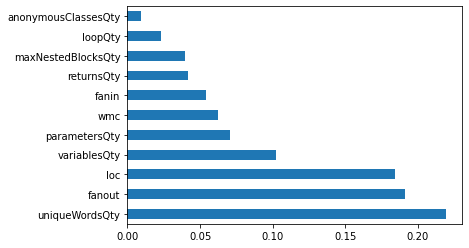

In [29]:
feat_importances = pd.Series(tuned_hyper_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

In [30]:
## Prediction
y_pred=tuned_hyper_model.predict(X_test)

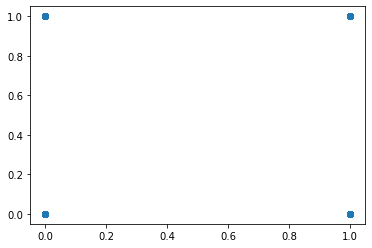

In [31]:
## Plot result
plt.scatter(y_test,y_pred)

In [32]:
## EVALUATE

In [33]:
## Evaluate error rate
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.015651674188259555
MSE: 0.015651674188259555
RMSE: 0.1251066512550774


In [34]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [35]:
accuracy_score(y_test, y_pred.round())

0.9843483258117405

In [36]:
precision_score(y_test, y_pred.round())

0.7647058823529411

In [37]:
recall_score(y_test, y_pred.round())

0.05405405405405406

In [38]:
f1_score(y_test, y_pred.round())

0.10097087378640776